## DataLoaders requirements

* Use univariate and multivariate time series
* Use labeled (X,y) and unlabeled (X,) datasets
* In-memory and on-disk np.arrays (np.memmap)
* Slice the dataset (based on selected variables and/ or sequence steps)
* Use item and batch tfms
* Create batch with specified output types (TSTensor, TensorCategory, etc)
* Show batch (with tfms)
* Show results
* Add test data and unlabeled datasets
* Better performance than native Pytorch, fastai v1 & vanilla fastai v2

## Import libraries

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

/content/timeseriesAI2
/content/timeseriesAI2


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [0]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.vision.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [0]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

## Load data

In [5]:
# dataset id
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_in_memory = np.concatenate((X_train, X_valid))
y_in_memory = np.concatenate((y_train, y_valid)).astype(int)
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X_in_memory)
np.save(f'{folder}/{dsid}/y.npy', y_in_memory)
X_on_disk = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y_on_disk = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r').astype(int)
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X_on_disk)))))

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



## Performance benchmark

### Pytorch

In [0]:
# Native Pytorch
class PytorchDataset():
    def __init__(self, X, y=None): self.X, self.y = torch.as_tensor(X), torch.as_tensor(y)
    def __getitem__(self, idx): return (self.X[idx], self.y[idx])
    def __len__(self): return len(self.X)

In [7]:
ds    = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dl    = torch.utils.data.DataLoader(ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(len(ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dl)

shape: 8236         bs: torch.Size([128, 1, 1024])
10 loops, best of 3: 65.5 ms per loop


### Fastai v1

For reference, this are the timings achieved with fastai v1 under the same conditions: 

- cycle_dl:  1.01s
- total training time: 102 s

### Fastai v2

In [8]:
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 3.43 s per loop


Sylvain's recommendation

In [9]:
train_ds = PytorchDataset(np.array(X_train), np.array(y_train).astype(int))
valid_ds = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 892 ms per loop


## NumpyDatasets & NumpyDataLoader

In [0]:
# class Datasets(FilteredBase):
#     "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
#     def __init__(self, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
#         super().__init__(dl_type=dl_type)
#         self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
#         self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

#     def __getitem__(self, it):
#         res = tuple([tl[it] for tl in self.tls])
#         return res if is_indexer(it) else list(zip(*res))

#     def __getattr__(self,k): return gather_attrs(self, k, 'tls')
#     def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
#     def __len__(self): return len(self.tls[0])
#     def __iter__(self): return (self[i] for i in range(len(self)))
#     def __repr__(self): return coll_repr(self)
#     def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
#     def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
#     def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
#     def overlapping_splits(self): return self.tls[0].overlapping_splits()
#     def new_empty(self): return type(self)(tls=[tl.new_empty() for tl in self.tls], n_inp=self.n_inp)
#     @property
#     def splits(self): return self.tls[0].splits
#     @property
#     def split_idx(self): return self.tls[0].tfms.split_idx
#     @property
#     def items(self): return self.tls[0].items
#     @items.setter
#     def items(self, v):
#         for tl in self.tls: tl.items = v

#     def show(self, o, ctx=None, **kwargs):
#         for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
#         return ctx

#     @contextmanager
#     def set_split_idx(self, i):
#         old_split_idx = self.split_idx
#         for tl in self.tls: tl.tfms.split_idx = i
#         yield self
#         for tl in self.tls: tl.tfms.split_idx = old_split_idx


In [0]:
def is_none(o):
    return o in [[], [None], None]
    
def ifnotnone(a, b):
    "`a` if `a` is None else `b`"
    return a if a is not None else b

def ifnoneelse(a, b, c):
    "`b` if `a` is None else `c`"
    return b if a is None else c

In [0]:
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = None, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 preprocess=False, **kwargs):

        if tls is None: items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = slice(None) if sel_vars is None else sel_vars
        self.sel_steps = slice(None) if sel_steps is None else sel_steps
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        self.ptls = L([tl.items if is_none(tfm) else np.stack(tl[:]) if preprocess else tl for tl,tfm in zip(self.tls, self.tfms)])
        self._get_types()
        self.preprocess = preprocess
            
    def _get_types(self):
        if self.tls: 
            self.types = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else torch.as_tensor for tl in self.tls]
            if self._xtype is not None: self.types[0] = self._xtype
            if len(self.types) == 2 and self._ytype is not None: self.types[1] = self._ytype
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it][self.sel_vars, self.sel_steps] if i==0 else ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           preprocess=self.preprocess, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = ifnone(items,ifnoneelse(y,tuple((X,)),tuple((X, y))))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    @property
    def vars(self): return self[0][0].shape[-2]

class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    
class NumpyDataLoader(TfmdDL):
    do_item = noops
    
    def create_batch(self, b): return self.dataset[b]
    
    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        b = self.one_batch()
        b = itemify(b)
        if nrows is None: 
            sqrt = math.sqrt(len(b))
            rows = min(math.ceil(sqrt), len(b)) 
        if ncols is None: ncols = len(b) // nrows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(b[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(self.dataset.decode(tup), ax=ax)
            plt.tight_layout()

@delegates(plt.subplots)
def show_tuple(tup, ax=None, **kwargs):
    "Display a timeseries plot from a tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], ax=ax, **kwargs)
    
class TSDataLoader(NumpyDataLoader): pass

In [0]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

(TSTensor(vars:1, len:1024), TensorCategory(1))


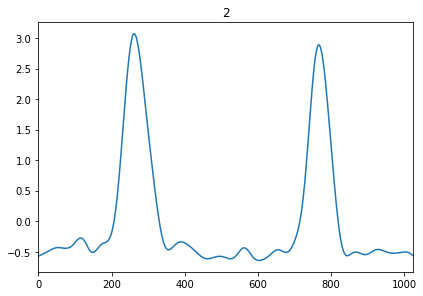

In [243]:
tfms = [None, [Categorize()]]
# tfms = None
# dsets = NumpyDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=False)
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=False)
train_ds = dsets.train
valid_ds = dsets.valid
print(valid_ds[0])
show_at(valid_ds, 0);

In [277]:
dsets.tls[0].tfms.fs[0]

noop: (object,object) -> noop 

In [269]:
dsets.tls[0].tfms == str('Pipeline')

False

In [258]:
len(dsets.tls[0].tfms.fs) and dsets.tls[0].tfms.fs[0].name == 'noop'

True

In [11]:
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls = TSDataLoaders(train_dl, valid_dl)
b = next(iter(dls.valid))
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
         1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
         2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
         1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
         2, 2, 2, 2, 1, 2, 2, 0]))

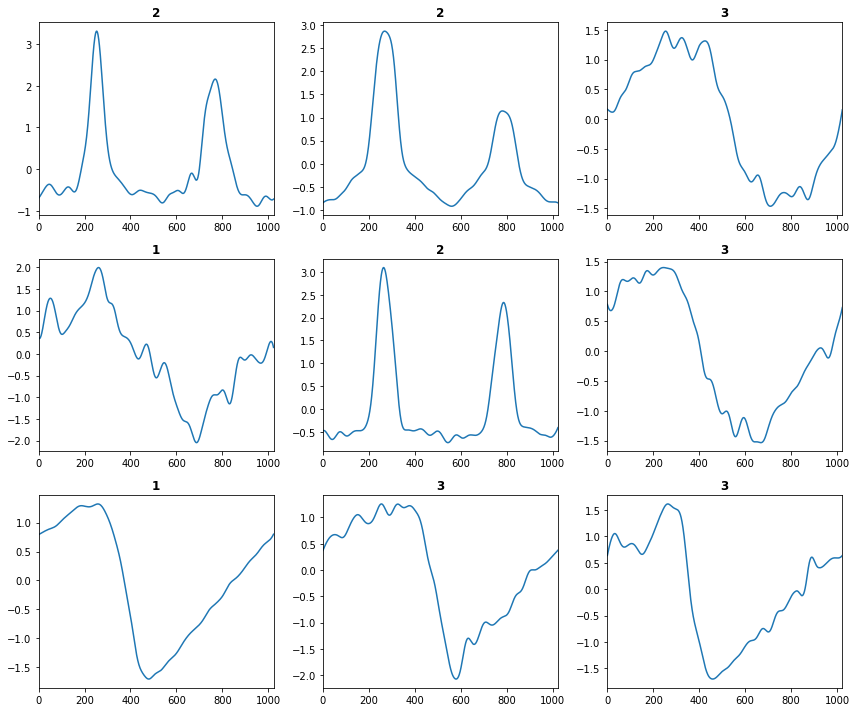

In [22]:
dls.train.show_batch()

In [23]:
X_val = X_in_memory[splits[1]]
y_val = y_in_memory[splits[1]]
%timeit tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 198 µs per loop


In [26]:
%timeit valid_ds[valid_idx]

100 loops, best of 3: 14.5 ms per loop


In [27]:
%timeit cycle_dl(valid_dl)

1 loop, best of 3: 929 ms per loop


In [20]:
%timeit valid_ds[valid_idx]

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 186 µs per loop


In [31]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 37 ms per loop


In [25]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.730351,1.026829,0.798567,00:02
1,0.582621,0.644263,0.845920,00:02
2,0.486823,0.408003,0.852477,00:02
3,0.414061,0.607993,0.692448,00:02
4,0.347909,0.663359,0.855755,00:02
5,0.298066,0.179185,0.951797,00:02
6,0.251365,0.192588,0.930306,00:02
7,0.211995,0.255828,0.932127,00:02
8,0.180487,0.470174,0.857334,00:02
9,0.154197,0.240356,0.905901,00:02


73.67140460014343


In [9]:
# Preprocess = False, Data_on_disk
tfms = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True)
valid_dl = TSDataLoader(valid_ds, bs=128)
dls = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.799278,1.068762,0.577222,00:03
1,0.647836,0.694410,0.835600,00:03
2,0.546813,0.423343,0.851627,00:03
3,0.451487,0.337685,0.856484,00:03
4,0.392121,0.434699,0.834628,00:03
5,0.338288,0.906969,0.849077,00:03
6,0.302274,0.739665,0.855027,00:03
7,0.265216,0.229490,0.928485,00:03
8,0.227199,0.891239,0.787882,00:03
9,0.200662,0.167834,0.956897,00:03


82.7504723072052


In [104]:
# Preprocess = False
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=False)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn2 = Learner(dls, model, metrics=accuracy)
start = time.time()
learn2.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.705418,1.009921,0.676663,00:03
1,0.570929,0.650547,0.831836,00:03
2,0.493112,0.624059,0.746479,00:03
3,0.418206,0.274643,0.894609,00:03
4,0.362605,0.542397,0.773434,00:03
5,0.307633,0.274911,0.875304,00:03
6,0.261671,1.009938,0.856484,00:03
7,0.236244,0.156257,0.944998,00:03
8,0.202548,0.127820,0.968310,00:03
9,0.176167,0.111701,0.974259,00:03


97.16755080223083


In [0]:
@typedispatch
def show_results(x:TSTensor, y:TensorCategory, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    print(samples)
    print()
    print(outs)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize)
    for i in range(2):
        ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    ctxs = [r.show(ctx=c, color='green' if b==r else 'red', **kwargs)
            for b,r,c,_ in zip(samples.itemgot(1),outs.itemgot(0),ctxs,range(max_n))]
    return ctxs

In [0]:
TfmdDL.show_results??

In [0]:
def show_batch(self, b=None, max_n=9, ctxs=None, show=True, unique=False, **kwargs):
        if unique:
            old_get_idxs = self.get_idxs
            self.get_idxs = lambda: Inf.zeros
        if b is None: b = self.one_batch()
        if not show: return self._pre_show_batch(b, max_n=max_n)
        show_batch(*self._pre_show_batch(b, max_n=max_n), ctxs=ctxs, max_n=max_n, **kwargs)
        if unique: self.get_idxs = old_get_idxs

In [0]:
def show_results(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
    x,y,its = self.show_batch(b, max_n=max_n, show=False)
    b_out = type(b)(b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,)))
    x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
    res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
    if not show: return res
    show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)

In [0]:
valid_dl.

In [300]:
b = valid_dl.one_batch()
learn.get_preds(dl=b, with_decoded=True, save_preds=None, save_targs=None)

IndexError: ignored

In [33]:
b = valid_dl.one_batch()
valid_dl.show_results(b, )

TypeError: ignored

In [72]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(5, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.685907,0.945180,0.795775,00:02
1,0.506659,0.462008,0.835357,00:02
2,0.406457,0.371313,0.855998,00:02
3,0.331253,0.314374,0.858791,00:02
4,0.277671,0.173735,0.968188,00:02


14.656439065933228


In [0]:
class TSTensor(TensorBase):
    '''Returns a tensor of at least 2 dims of type torch.float32 and class TSTensor'''
    def __new__(cls, o, dtype=torch.float32, **kwargs): 
        res = ToType(dtype)(To2DPlusTensor(o))
        res.__class__ = cls
        res._meta = kwargs
        return res

    @property
    def vars(self): return self.shape[-2]

    @property
    def len(self): return self.shape[-1]
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim >= 3:   return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 2: return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 1: return f'TSTensor(len:{self.shape[-1]})'
        else: return f'TSTensor(float)'

    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax

In [0]:
@typedispatch
def show_results(xb:TSTensor, yb, preds, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    t = dl.decode_batch((xb,yb))
    p = dl.decode_batch((xb,preds))

    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(xb.shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'True: {t[i][1]}\nPred: {p[i][1]}'
        color = 'green' if t[i][1] == p[i][1] else 'red'
        t[i][0].show(ctx=ctx, title=title, title_color=color)

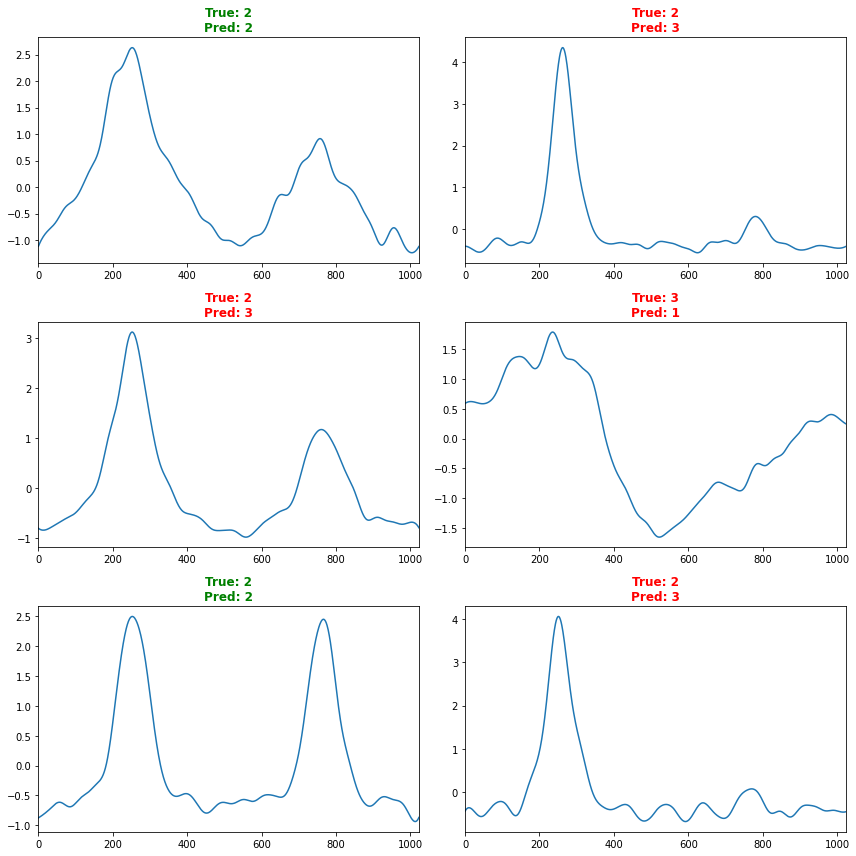

In [75]:
ds_idx = 1
dl = None
max_n=9
shuffle=True
kwargs = {}
if dl is None: dl = learn.dls[ds_idx].new(shuffle=shuffle)
xb,yb = dl.one_batch()
_,_,preds = learn.get_preds(dl=dl, with_decoded=True)
show_results(xb, yb, preds, max_n=max_n, **kwargs)
# dls.show_results()

In [70]:
xb,yb = dl.one_batch()
t = dl.decode_batch((xb,yb))
p = dl.decode_batch((xb,preds))
t[0][0].show(title=t[0][1], title_color='red');

TypeError: ignored

In [0]:
@typedispatch
def show_results(x:TSTensor, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    print(1)
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'{[False,True][x[2][i].item()]}\n{[False,True][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

# DataLoaders.show_results

In [0]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'{[False,True][x[2][i].item()]}\n{[False,True][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

In [317]:
ds_idx = 1
dl = None
max_n=9
shuffle=True
kwargs = {}
if dl is None: dl = learn.dls[ds_idx].new(shuffle=shuffle)
b = dl.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)
print(preds)
learn.dls.show_results(b, preds, max_n=max_n, **kwargs)

tensor([0, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2,
        2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0,
        1, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2,
        2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 0,
        2, 2, 2, 2, 2, 2, 1, 2])


TypeError: ignored

TypeError: ignored

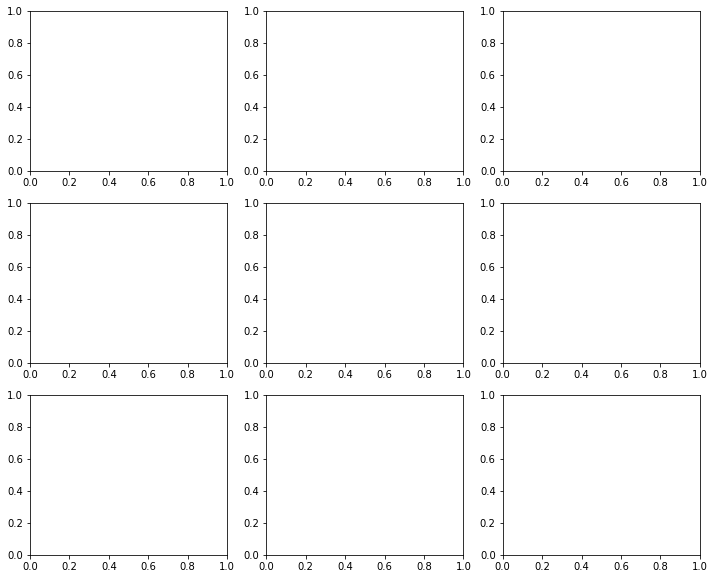

In [320]:
# dls.show_results(b, preds, max_n=max_n, **kwargs)
dls.show_batch(b, max_n=max_n, show=False)

In [311]:
learn.show_results()

tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
        2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 2, 0,
        2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2,
        0, 2, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 2, 2,
        2, 0, 2, 2, 0, 1, 1, 2])


TypeError: ignored

In [91]:
b = valid_dl.one_batch()
valid_dl.show_results()

TypeError: ignored

In [296]:
train_probas, train_targets, train_preds = learn.get_preds(dl=train_dl, with_decoded=True, save_preds=None, save_targs=None)
train_probas, train_targets, train_preds

(tensor([[3.7527e-02, 1.3547e-03, 9.6112e-01],
         [5.3250e-01, 2.3560e-03, 4.6515e-01],
         [9.9545e-01, 8.8908e-04, 3.6597e-03],
         ...,
         [9.6731e-01, 2.1833e-03, 3.0508e-02],
         [4.0642e-03, 3.0125e-03, 9.9292e-01],
         [5.9935e-03, 1.8590e-03, 9.9215e-01]]),
 tensor([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
         1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
         2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 2,
         2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2,
         1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2,
         2, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [125]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True, save_preds=None, save_targs=None)
valid_probas, valid_targets, valid_preds

(tensor([[3.9338e-05, 9.9962e-01, 3.4185e-04],
         [1.8641e-01, 6.2091e-02, 7.5150e-01],
         [6.3632e-02, 2.8929e-02, 9.0744e-01],
         ...,
         [9.9691e-01, 3.6535e-04, 2.7261e-03],
         [4.7219e-04, 9.9885e-01, 6.7478e-04],
         [5.6984e-02, 3.3776e-03, 9.3964e-01]]),
 tensor([1, 2, 2,  ..., 0, 1, 2]),
 tensor([1, 2, 2,  ..., 0, 1, 2]))

In [0]:
def add_ds(dsets, X=None, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create a test or unlabeled datasets from X (and y) using validation transforms of `dsets`"
    items = tuple((X,)) if y is None else tuple((X, y))
    with_labels = False if y is None else True
    if isinstance(dsets, (Datasets, NumpyDatasets, TSDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        # new_tls = [tl._new(items, split_idx=1) for tl in tls]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(item)) for tl,item in zip(new_tls, items)]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, (NumpyDatasets, TSDatasets)):
            cls = dsets.__class__
            return cls(tls=new_tls, n_inp=dsets.n_inp, preprocess=dsets.preprocess, tfms=dsets.tfms, sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps)
        elif isinstance(dsets, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

NumpyDatasets.add_ds = add_ds
TSDatasets.add_ds = add_ds

In [292]:
# Labeled test data
test_ds = dsets.add_ds(X_in_memory, y_in_memory)
test_dl = valid_dl.new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
         1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
         2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 1, 2, 0, 2], device='cuda:0'))

In [293]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[3.7527e-02, 1.3547e-03, 9.6112e-01],
         [5.3250e-01, 2.3560e-03, 4.6515e-01],
         [9.9545e-01, 8.8908e-04, 3.6597e-03],
         ...,
         [9.9691e-01, 3.6535e-04, 2.7261e-03],
         [4.7219e-04, 9.9885e-01, 6.7478e-04],
         [5.6984e-02, 3.3776e-03, 9.3964e-01]]),
 tensor([2, 2, 0,  ..., 0, 1, 2]),
 tensor([2, 0, 0,  ..., 0, 1, 2]))

In [294]:
unlabeled_ds = dsets.add_ds(X_in_memory)
unlabeled_dl = valid_dl.new(unlabeled_ds)
b = next(iter(unlabeled_dl))
b

(TSTensor(samples:128, vars:1, len:1024),)

In [295]:
u_probas, _ = learn.get_preds(dl=unlabeled_dl, save_preds=None)
u_probas

tensor([[3.7527e-02, 1.3547e-03, 9.6112e-01],
        [5.3250e-01, 2.3560e-03, 4.6515e-01],
        [9.9545e-01, 8.8908e-04, 3.6597e-03],
        ...,
        [9.9691e-01, 3.6535e-04, 2.7261e-03],
        [4.7219e-04, 9.9885e-01, 6.7478e-04],
        [5.6984e-02, 3.3776e-03, 9.3964e-01]])